# View and process the results of a geoclaw run

In [1]:
#set up environment and imported modules

import os
os.environ['CLAW'] = 'Users/anitamiddleton/Documents/python/clawpack'
os.environ['FC'] = 'gfortran'
dir = 'Users/anitamiddleton/Documents/python/tsunami_proj/urakawa1982'
%pylab inline

from clawpack.clawutil import nbtools
from clawpack.visclaw import animation_tools
from IPython.display import HTML, Image
from clawpack.geoclaw import dtopotools
import matplotlib.pyplot as plt
import numpy as np
%matplotlib widget

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
def show_anim(anim):
    html_version = HTML(anim.to_jshtml())
    # html_version = HTML(anim.to_html5_video())
    return html_version

In [ ]:
# read in results
plotdir = os.path.join(dir, 'geoclaw/examples/urakawa1982/_plots')
anim = animation_tools.animate_from_plotdir(plotdir, figno=0)
show_anim(anim)

## Output Gauge Results

In [10]:
# Process observation data

# Read in observations for Urakawa
scratch_dir = '/Users/anitamiddleton/Documents/python/tsunami_proj/scratch/urakawa1982'
gauge_path = os.path.join(scratch_dir, 'tide_gauge_observations/urakawa_raw_observations.csv') # observed tide gauge data
tide_path = os.path.join(scratch_dir, 'tide_gauge_observations/urakawa_tidal_component.csv') # tidal component

raw_observations = np.loadtxt(gauge_path, delimiter=',', skiprows=1) # x,y time,height
tidal_component = np.loadtxt(tide_path, delimiter=',', skiprows=1)

# column for time, tide gauge measurements, tidal component, measurements-tidal component
tide_data = np.empty((raw_observations.shape[0], 4))
# the earthquake happened at 11:32 JST, time for csv files begins around 11 JST

tide_data[:,0] = raw_observations[:,0] # time JST
tide_data[:,1] = raw_observations[:,1] # tide gauge measurement
tidal_component = np.vstack((tidal_component[0], tidal_component)) # one data point short by accident
tide_data[:,2] = tidal_component[:,1] # don't need times, only data
tide_data[:,3] = tide_data[:,1] - tide_data[:,2] 

# grab the correct times, but we only need 11:30 and beyond
tide_data[:,0] = tide_data[:,0]*60 # convert to minutes
event_time = 11.5 * 60
sorting = tide_data[:,0] > event_time

gauge_data = tide_data[::][sorting]
gauge_data[:,0] = gauge_data[:,0] - event_time # time shift so that time 0 is the earthquake


# observations for Erimo

gauge_path = os.path.join(scratch_dir, 'tide_gauge_observations/erimo_tidal_observations.csv') # observed tide gauge data
observed_erimo = np.loadtxt(gauge_path, delimiter=',', skiprows=1) # x,y time,height


# observations for Tomakomai

gauge_path = os.path.join(scratch_dir, 'tide_gauge_observations/tomakomai_raw_observations.csv') # observed tide gauge data
tide_path = os.path.join(scratch_dir, 'tide_gauge_observations/tomakomai_tidal_component.csv')
observed_tomakomai = np.loadtxt(gauge_path, delimiter=',', skiprows=1) # x,y time,height
tomakomai_tide = np.loadtxt(tide_path, delimiter=',', skiprows=1)


Read in gauge 129.
Read in gauge 112.
Read in gauge 113.


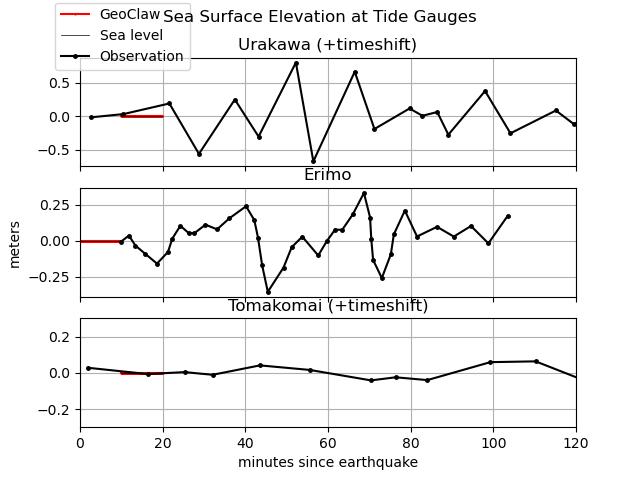

In [11]:
# plot combined gauge results from all gauges and their observations to compare

from setplot import setplot
plotdata = setplot()

time_shift = 10 # 10 minutes
plotdata.outdir = '_output'
g129 = plotdata.getgauge(129)
t = (g129.t / 60.) + time_shift # convert to minutes 
eta = g129.q[3,:]   # eta = h + B (depth plus bathymetry)

g112 = plotdata.getgauge(112)
t2 = (g112.t / 60.) # convert to minutes 
eta2 = g112.q[3,:]   # eta = h + B (depth plus bathymetry)

g113 = plotdata.getgauge(113)
t3 = (g113.t / 60.) + time_shift # convert to minutes and shift
eta3 = g113.q[3,:]   # eta = h + B (depth plus bathymetry)

# plot the comparison
plt.close('all')
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
fig.suptitle('Sea Surface Elevation at Tide Gauges')
ax1.set_title("Urakawa (+timeshift)")
ax1.plot(t,eta, 'r.-', markersize=1, label='GeoClaw')
ax1.plot(gauge_data[:,0], gauge_data[:,3]/100, 'k.-', markersize=5, label='Observation') # convert cm to m
ax1.plot(t,0*t, 'k-', label='Sea level', linewidth=0.5)
ax1.grid(True)
#ax1.set_ylabel("meters")

ax2.set_title("Erimo")
ax2.plot(t2,eta2, 'r.-', markersize=1, label='GeoClaw')
ax2.plot(observed_erimo[:,0]*60 + time_shift, (observed_erimo[:,1]/100)-0.04, 'k.-', markersize=5, label='Observation') # cm to m in erimo observations
ax2.plot(t2,0*t2, 'k-', label='Sea level', linewidth=0.5)
ax2.grid(True)
ax2.set_ylabel("meters")

ax3.set_title("Tomakomai (+timeshift)")
ax3.plot(t3,eta3, 'r.-', markersize=1, label='GeoClaw')
ax3.plot(t3,0*t3, 'k-', label='Sea level', linewidth=0.5)
ax3.plot(observed_tomakomai[:,0]*60, (observed_tomakomai[:,1]-tomakomai_tide[:,1])/100, 'k.-', markersize=5, label='Observation') 
ax3.grid(True)
ax3.set_ylim(-0.3, 0.3)
plt.xlim(0,120)
plt.xlabel('minutes since earthquake')
#plt.ylabel('meters')
plt.legend(bbox_to_anchor=(-0.05, 3.905), loc='upper left', borderaxespad=0.)
plt.show()

## Process Fgmax data

In [12]:
# read in fgmax data

# for rundata.fgmax_data.num_fgmax_val = 1 : 
# columns in file: lon, lat, amr_level, topo value B, maximum depth h, time of max h, arrival time 

from clawpack.visclaw import colormaps
from clawpack.visclaw import plottools
from clawpack.visclaw.plottools import pcolorcells
from clawpack.geoclaw import fgmax_tools
from matplotlib import colors 
import glob

fg = fgmax_tools.FGmaxGrid()
outdir = '_output'
fg.outdir = outdir
data_file = 'fgmax_grids.data'
fg.read_fgmax_grids_data(fgno=1, data_file=data_file) # currently only one fgmax grid used
fg.read_output()

t_files = glob.glob(outdir + '/fort.t0*') # grabs all the timing files 
times = []
for f in t_files:
    lines = open(f,'r').readlines()
    for line in lines:
        if 'time' in line: 
            t = float(line.split()[0])
    times.append(t)
times.sort()
print('Output times found: ',times)
if len(times) > 0:
    t_hours = times[-1] / 3600.
    print('\nfgmax results are presumably from final time: %.1f seconds = %.2f hours'\
          % (times[-1], t_hours))
else:
    t_hours = np.Nan


# read in initial topography/bathymetry values for fgmax grid before dtopo event
fname = 'scratch/Hokkaido_B0.txt'
print('Loading B0 from %s' % fname)
B0 = np.loadtxt(fname)
B0_masked = np.ma.masked_array(B0, fg.B.mask)
fg.dz = fg.B - B0_masked
fg.B0 = B0_masked

print('Maximum dz between fg.B and new fg.B0 = %.3f'  % abs(fg.B0 - fg.B).max())

Reading input for fgno=1, point_style = 4 
Reading _output/fgmax0001.txt ...
point_style == 4, found 86341 points 
Will map fgmax points onto masked arrays defined by file:
     /Users/anitamiddleton/Documents/python/urakawa1982/scratch/fgmax_pts_topostyle.data
*** Problem converting from 1d lists to 2d arrays,
    Trying to map onto grid specified by:
     /Users/anitamiddleton/Documents/python/urakawa1982/scratch/fgmax_pts_topostyle.data


FileNotFoundError: [Errno 2] No such file or directory: '/Users/anitamiddleton/Documents/python/urakawa1982/scratch/fgmax_pts_topostyle.data'

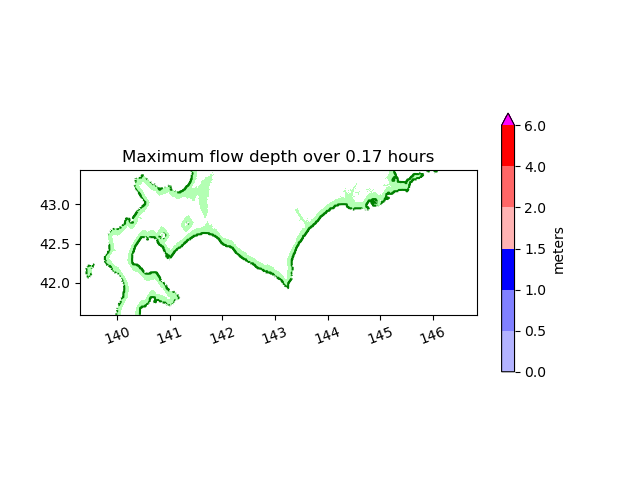

In [12]:
# plot onshore inundation
# code taken from https://depts.washington.edu/ptha/WA_EMD_2021/ process_fgmax.py
# For plotting the inundation depth on shore without showing offshore depths, and for plotting `eta = B + h` only offshore.

# find onshore and offshore points of the grid
onshore = fg.B0 > 0.0
if fg.force_dry_init is not None:
    onshore = np.logical_or(onshore, fg.force_dry_init)
offshore = np.logical_not(onshore)

fg.h_onshore = np.ma.masked_where(offshore, fg.h)
fg.eta_offshore = np.ma.masked_where(onshore, fg.B0 + fg.h)  # use B0 for continuity at shore


# ## Plot maximum flow depth
bounds_depth = np.array([1e-6,0.5,1.0,1.5,2,4.0,6.0]) 
cmap_depth = colors.ListedColormap([[.7,.7,1],[.5,.5,1],[0,0,1], [1,.7,.7], [1,.4,.4], [1,0,0]])

# Set color for value exceeding top of range to purple:
cmap_depth.set_over(color=[1,0,1])

# Set color for land points without inundation to light green:
cmap_depth.set_under(color=[.7,1,.7])
norm_depth = colors.BoundaryNorm(bounds_depth, cmap_depth.N)
    
plt.close('all')
fig, ax = plt.subplots()
figsize=(8,10)
pc = plottools.pcolorcells(fg.X, fg.Y, fg.h_onshore, cmap=cmap_depth, norm=norm_depth)
cb = plt.colorbar(pc, extend='max', shrink=0.7)
cb.set_label('meters')
plt.contour(fg.X, fg.Y, fg.B0, [0], colors='g')

ax.set_aspect(1./np.cos(48*np.pi/180.))
plt.ticklabel_format(useOffset=False)
plt.xticks(rotation=20)
plt.title('Maximum flow depth over %.2f hours' % t_hours)
plt.show()

# In the plot above, green shows fgmax points that never got wet.  
# The green contour shows `B0 = 0`, and note that some of the initially dry region below MHW never got wet 
# (over the limited duration of this simulation).
# 
# White areas are masked out either because they were not fgmax points or because they were initially wet. 
# 
# Regions colored blue or red are initially dry fgmax points that did get wet during the tsunami, 
# with color showing the maximum depth of water recorded.